Functions:
- load dico, matrices and model pickles

- file2ia (your_file)
        + copy/paste output to dictionary variable (e.g., gui_n = {})
- ia2d3(gui_n)
- ia2test_set(gui_n)
        + copy/paste output to list variable (e.g., test_set_n)    #do not forget comas after each tupple
                                                                   #text processing issues with score_fam functions

- test2df (gui_n, test_set_n)                                      #text processing issues here too
        + give output to variable name (e.g., data_gui_n)
- plots (data_frame)
- anovas (data_frame)
- regressions (data_frame)
- goal_matrix (data_frame)

In [2]:
import pickle, operator, json, requests

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Natural Language Processing modules
from gensim import corpora, models, similarities, utils
from pattern.en import tag, parse
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import RegexpTokenizer

# Data/Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics and Machine-learning modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import datasets, linear_model

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# IA handling

In [ ]:
def file2ia (your_file):
    
    def getLineInfo(fname):

        raw_line = next(fname, None)
        if raw_line is None:
            return False
        full_line = raw_line.rstrip()
        text_only = full_line.lstrip()
        num_tabs = len(full_line) - len(text_only)
        return text_only, num_tabs

    def buildGUI(response, fname):
        # Assume it is a proper tuple:
        key, depth = response
        # Dictionary for this depth:
        local_gui = {}
        # This changes if depth goes up OR down, or reach EOF

        # technically infinite loop, but something will eventually break or return
        while 1:
            # 1. next_depth = same: make previous key/value
            # 2. next_depth +1: call function and make previous key/dict
            # 3. next_depth smaller: make previous key/value
            # 4. EOF: make previous key/value
            next_response = getLineInfo(fname)

            if not next_response:  #end of file
                local_gui[key] = key
                return local_gui, next_response
                break

            # Have a good response at this point
            next_key, next_depth = next_response

            # 2. Set key to result of recursive call
            if next_depth == depth + 1:
                # RECURSIVE CALL
                local_gui[key], last_response = buildGUI(next_response, fname)
                # Last response is next line after nested (recursive) part is finished
                # If depth less than current, return whatever GUI we have
                if last_response:
                    last_key, last_depth = last_response
                    if last_depth < depth:
                        return local_gui, last_response
                    # Otherwise set current key, depth and keep going
                    key, depth = last_response
                else:
                    return local_gui, last_response # RECURSIVE call reached end of file

            # 3. Next line is higher up the IA, so return what we have with next line
            elif next_depth < depth:
                local_gui[key] = key
                return local_gui, next_response
            # 1. same depth, just keep going
            else:
                local_gui[key] = key
                key = next_key

        return local_gui, next_response #print previous_key #, next_key

    my_file = open(your_file, 'r')
    first_response = getLineInfo(my_file)
    print first_response

    # throwaway variable _ will always be False
    GUI, _ = buildGUI(first_response, my_file)

    return GUI

# checking
#file2ia ('gui_5')

In [3]:
gui5 = {"car":{ "air conditioning":{ "ventilation settings": "ventilation settings","pulse": "pulse", "continuous": "continuous"}, 
                                    "filter settings":{ "recycle interior air": "recycle interior air", "charcoal mode": "charcoal mode", "pollen mode": "pollen mode"}, 
                                    "temperature settings":{ "display current temperature": "display current temperature", "hotter": "hotter", "colder": "colder"}}, 
                "driving assistance":{ "cruise control":{ "activate": "activate", "turn off": "turn off"}, 
                                        "anti theft protection":{ "choose notification recipient": "choose notification recipient", 
                                        "phone pairing tracking": "phone pairing tracking", "stop vehicle": "stop vehicle"},
                                        "lane change alert":{ "vibrate steering wheel": "vibrate steering wheel", "vibrate pedal": "vibrate pedal", "vibrate rear view mirrors": "vibrate rear view mirrors"},
                                        "gps":{ "check current coordinates": "check current coordinates", "enter destination": "enter destination", "recent destination": "recent destination"}},
                "entertainment":{ "gaming":{ "poker": "poker", "chess": "chess", "online apps": "online apps"},
                                 "television":{ "documentaries": "documentaries", "movies sorted":{ "genre": "genre", "rating": "rating", "release date": "release date"}, 
                                                                "tv series": "tv series"},
                                                                "radio":{ "classic": "classic", "pop": "pop", "electronic": "electronic"}},
                        "phone":{ "contact lists":{ "family": "family", "work": "work", "emergency": "emergency"}, "dial": "dial", "voice mail":{ "listen messages": "listen messages", 
                                                                    "erase last message": "erase last message", "change greetings": "change greetings"}, "pay bills": "pay bills"}}

In [ ]:
# This function generates IA description and syntax for drawing D3 dendrograms

def ia2d3 (dico):
    
    print 'gui = { "name": "home", "children":['
    
    def nested2d3(dico, indent = '   '):
        for k in dico.keys():
            print indent + '{ "name": "' + str(k) + '",'
            if isinstance(dico[k], dict):
                print indent + '"children":['
                nested2d3(dico[k], indent + "   ")
            if isinstance(dico[k], str):
                print indent + ' "size": 20},'
        print ']},'
    
    nested2d3(dico, indent = '   ')

# Checking    
#ia2d3(gui5)

# Test set generation

In [ ]:
def wraper1 (gui):
    
    def list_gui_target_features(gui, f_list=[], g_list=[], t_list=[]):
        for k in gui.keys():
            if type(gui[k]) is str:
                f_list.append(gui[k])
                g_list.append('')
                t_list.append('')
            else:
                list_gui_target_features(gui[k])                           
        return zip (f_list, g_list, t_list)
    
    return list_gui_target_features (gui)

In [ ]:
def wraper2 (gui, glob): 
    
    def steps_to_targ_feat (gui, glob , c_list = []):   
        for v in gui.values():   
            if type(v) is dict:
                steps_to_targ_feat(v, glob + 1)
            else:
                c_list.append(glob)     
        return c_list

    return steps_to_targ_feat(gui, glob)

In [ ]:
def ia2test_set(gui):
    f1 = wraper1 (gui)
    f2 = wraper2 (gui, 1)
    f3 = []
    for i, elem in enumerate(f1):
        temp = []
        for n in elem:
            temp.append(n)
        temp.append(f2[i])
        f3.append(tuple(temp))
    return f3
    
# checking
test_set_inter = ia2test_set(gui5)
for t in test_set_inter:
    print t

In [4]:
test_set_gui = [('pay bills', 'pay monthly phone plan', 'basic', 2),
('family', 'display address my parents', 'basic', 3),
('change greetings', 'record message welcoming message', 'technical', 3),
('rating', 'list best movies', 'technical', 4)]

# Wordnet Technicality check

In [22]:
def score_fam_wn (test_set):
    from nltk.corpus import wordnet as wn, stopwords
    from nltk.tokenize import RegexpTokenizer
    wn_fam = []
    for test in test_set:
        tokenizer = RegexpTokenizer(r'\w+')
        toketxt = tokenizer.tokenize(test[1])
        s = set(stopwords.words('english'))
        filt_wrd = [w for w in toketxt if not w in s]
        w_count = len(filt_wrd)
        g_polys = 0

        for word in filt_wrd:
            w_polys = len(wn.synsets(word))
            g_polys += w_polys

        av_polys = float(g_polys)/float(w_count)
        wn_fam.append(round(av_polys, 2))

    print sorted(wn_fam), '   >> wordnet familiarity' 
    return wn_fam
    
def score_fam_wn_NN (test_set):

    wn_fam_NN = []

    for test in test_set: 
        filt_wrd = []
        g = test[1]
        for w, pos in tag(g): 
            if pos == "NN":
                filt_wrd.append(w)
        #print filt_wrd

        w_count = len(filt_wrd)
        g_polys = 0

        for word in filt_wrd:
            w_polys = len(wn.synsets(word))
            g_polys += w_polys

        av_polys = float(g_polys)/float(w_count)
        wn_fam_NN.append(round(av_polys, 2))

    print sorted(wn_fam_NN), '   >> wordnet familiarity for NN pos only'
    return wn_fam_NN

[6.5, 6.75, 9.67, 17.0]    >> wordnet familiarity
[5.0, 5.5, 7.0, 8.0]    >> wordnet familiarity for NN pos only


# Models

In [6]:
# Load tf-idf representation and dictionary mapping for tokenized corpus
wiki = corpora.MmCorpus('latent_tok_tfidf.mm')
mon_dico = corpora.Dictionary.load_from_text('latent_tok_wordids.txt')

# Lemmatized tf-idf representation and dictionary
wiki_lem = corpora.MmCorpus('latent_lem_tfidf.mm')
mon_dico_lem = corpora.Dictionary.load_from_text('latent_lem_wordids.txt')

print "Tokenized corpus:", wiki
print mon_dico, '\n'
print "Lemmatized corpus:", wiki_lem
print mon_dico_lem

Tokenized corpus: MmCorpus(73898 documents, 29597 features, 6418219 non-zero entries)
Dictionary(29597 unique tokens: [u'fawn', u'schlegel', u'sonja', u'woods', u'spiders']...) 

Lemmatized corpus: MmCorpus(59245 documents, 26640 features, 5275674 non-zero entries)
Dictionary(26640 unique tokens: [u'adjust/VB', u'meteor/NN', u'certificate/NN', u'alcatraz/NN', u'removal/NN']...)


In [7]:
# Load model pickles
# Model training parameters:
#    - LSA and LDA: dictionary = 100,000; topics = 450
#    - Word2vec: dictionary = 100,000; neural layers = 200
    
tok_w2v = models.word2vec.Word2Vec.load("word2vec_tok.model")
lem_w2v = models.word2vec.Word2Vec.load("word2vec_lem.model")
tok_lsi = pickle.load (open ('pickle_lsi.p', 'rb'))
tok_lda = pickle.load (open ('pickle_lda.p', 'rb'))
lem_lsi = pickle.load (open ('pickle_lsi_lem.p', 'rb'))
lem_lda = pickle.load (open ('pickle_lda_lem.p', 'rb'))

# Sniffer

In [12]:
def sim_sort(state, model, goal, model_type):
    sorted_sims = []
    similaritiz = {}
    goal_v = []
    
    # Word2Vec models
    if (model_type == "w2v") or (model_type == "w2v_lem"):
        
        goal_v = goal.lower().split()
        if model_type == "w2v_lem":
            goal_v = utils.lemmatize(goal)

        for label in state.keys():
            k = label.split()
            if model_type == "w2v_lem":
                k = utils.lemmatize(label)
            sim = model.n_similarity(k, goal_v)
            similaritiz[label]=sim          #adding the similarity scores for any label

    # LSI/LDA models
    elif (model_type == "latent") or (model_type == "latent_lem"):
        
        goal_split = goal.lower().split()
        goal_bow = mon_dico.doc2bow(goal_split)
        if model_type == "latent_lem":
            goal_bow = mon_dico_lem.doc2bow(utils.lemmatize(goal))
        goal_v = model[goal_bow]
        
        ar = []
        for label in state.keys():
            k = label.split()
            if model_type == "latent_lem":
                k = utils.lemmatize(label)
            ar.append(k)

        state2index = [mon_dico.doc2bow(txt) for txt in ar]
        if model_type == "latent_lem":
            state2index = [mon_dico_lem.doc2bow(txt) for txt in ar]
        index = similarities.MatrixSimilarity(model[state2index], num_features=29000)
        indexed_scores = list(index[goal_v])
        
        for index, score in enumerate(indexed_scores):       #this could be replaced by zip()
            label = state.keys()[index]
            similaritiz[label] = score
        
    sorted_sims = sorted(similaritiz.items(), key=operator.itemgetter(1), reverse = True) 
    #print sorted_sims
    return sorted_sims                              #returns a list of tuples i.e [(,), (,)]


#Check output
#print sim_sort(gui5, tok_w2v, 'cook chicken', 'w2v'), "\n"
#print sim_sort(gui5, lem_lsi, 'cook chicken', 'latent_lem'), "\n"
#print sim_sort(gui5, tok_lsi, 'cook chicken', 'latent'), "\n"

In [13]:
def sniffer_metrics(gui, model, goal, target_feat, model_type, global_count = 0):
    
    state = sim_sort(gui, model, goal, model_type)    #returned content must be assigned to a variable
    found_goal = False
    for label, score in state:
        global_count += 1
        
        if type(gui[label]) is dict:
            found_goal, g_cnt = sniffer_metrics(gui[label], model, goal, target_feat, model_type)
            global_count += g_cnt
            if found_goal:
                return True, global_count
    
        elif gui[label] == target_feat:
            return True, global_count

    return False, global_count

# Check output
# sniffer_metrics(gui5, tok_w2v, 'turn off cruise control', 'activate', 'w2v'), '\n'

# Model tester

In [14]:
def model_test(gui, test_set, model, model_type):
    
    wn_fam = score_fam_wn (test_set_gui)
    wn_fam_NN = score_fam_wn_NN (test_set_gui)
    
    test_metrics =[]
    goal_l = []
    target_l=[]
    prescrit=[]
    fam = []
    
    for a, b, c, d in test_set:
        goal_l.append(b)
        target_l.append(a)
        fam.append(c)
        prescrit.append(d)
        result = sniffer_metrics(gui, model, b, a, model_type)
        test_metrics.append(result[1])
    
    print test_metrics
    return zip(target_l, goal_l, test_metrics, prescrit, fam, wn_fam, wn_fam_NN)

# checking
# model_test(gui5, test_set_gui, tok_w2v, 'w2v')

# Dataframe

In [23]:
def test2df (gui_n, test_set_n):
    tok_w2v_test = model_test(gui_n, test_set_n, tok_w2v, 'w2v')
    lem_w2v_test = model_test(gui_n, test_set_n, lem_w2v, 'w2v_lem')
    tok_lsi_test = model_test(gui_n, test_set_n, tok_lsi, 'latent')
    tok_lda_test = model_test(gui_n, test_set_n, tok_lda, 'latent')
    lem_lsi_test = model_test(gui_n, test_set_n, lem_lsi, 'latent_lem')
    lem_lda_test = model_test(gui_n, test_set_n, lem_lda, 'latent_lem')

    df_tok_w2v = pd.DataFrame(tok_w2v_test)
    df_tok_w2v['model']='word2vec'
    df_tok_w2v['prepping']='tokens'

    df_lem_w2v = pd.DataFrame(lem_w2v_test)
    df_lem_w2v['model']='word2vec'
    df_lem_w2v['prepping']='lemmas'

    df_tok_lsi = pd.DataFrame(tok_lsi_test)
    df_tok_lsi['model']='lsi'
    df_tok_lsi['prepping']='tokens'

    df_tok_lda = pd.DataFrame(tok_lda_test)
    df_tok_lda['model']='lda'
    df_tok_lda['prepping']='tokens'

    df_lem_lsi = pd.DataFrame(lem_lsi_test)
    df_lem_lsi['model']='lsi'
    df_lem_lsi['prepping']='lemmas'

    df_lem_lda = pd.DataFrame(lem_lda_test)
    df_lem_lda['model']='lda'
    df_lem_lda['prepping']='lemmas'

    frames = [df_tok_w2v, df_lem_w2v, df_tok_lsi, df_tok_lda, df_lem_lsi, df_lem_lda]
    df_gui_n = pd.concat(frames)
    df_gui_n.columns = ['target_feat','goal',  'counts','prescrite','familiarity','wn_familiarity','wn_familiarity_NN','model', 'prepping']

    return df_gui_n

#checking
#
a = test2df (gui5, test_set_gui)
a.head (5)

[2, 10, 5, 6]
[7, 3, 5, 5]
[2, 4, 22, 6]
[2, 54, 50, 22]
[7, 37, 6, 12]
[2, 50, 56, 24]


,target_feat,goal,counts,prescrite,familiarity,wn_familiarity,wn_familiarity_NN,model,prepping
0,pay bills,pay monthly phone plan,2,2,basic,6.50,5.5,word2vec,tokens
1,family,display address my parents,10,3,basic,9.67,8.0,word2vec,tokens
2,change greetings,record message welcoming message,5,3,technical,6.75,5.0,word2vec,tokens
3,rating,list best movies,6,4,technical,17.00,7.0,word2vec,tokens
0,pay bills,pay monthly phone plan,7,2,basic,6.50,5.5,word2vec,lemmas


# Results

In [37]:
def plots (data_frame):
    #boxplots
    data_frame.boxplot(column = 'counts', by = 'model')
    data_frame.boxplot(column = 'counts', by = 'prepping')
    data_frame.boxplot(column = 'counts', by = 'familiarity')
    data_frame.boxplot(column = 'counts', by = 'prescrite')
    
    #factor plots
    e = sns.factorplot(x="familiarity", y="counts", col = 'model', hue="prepping",data=data_frame,
                       palette="YlGnBu_d", size=5, aspect=.75)
    e.despine(left=True)

def regressions (data_frame):
    selecta = data_frame[data_frame['model'] != 'lda']
    print 'Regression familiarity vs wn_NN'

    X = selecta['wn_familiarity_NN']
    Y = selecta['counts']

    regr = linear_model.LinearRegression()
    regr.fit (X[:,np.newaxis], Y)

    plt.xlabel('familiarity')
    plt.scatter(X, Y, color='red')
    plt.plot(X, regr.predict(X[:,np.newaxis]), color='blue')
    plt.show()

    # The coefficients
    print 'Coefficients: %.3f' % regr.coef_[0]
    # The mean square error
    print "Mean residual sum of squares: %.1f" % np.mean((regr.predict(X[:,np.newaxis]) - Y) ** 2)
    # Explained variance score: 1 is perfect prediction
    print('Variance of Y explained by X: %.3f' % regr.score(X[:,np.newaxis], Y))
    
    print 'Regression familiarity vs wn'
    X = selecta['wn_familiarity']
    Y = selecta['counts']

    regr = linear_model.LinearRegression()
    regr.fit (X[:,np.newaxis], Y)

    plt.xlabel('familiarity')
    plt.scatter(X, Y, color='red')
    plt.plot(X, regr.predict(X[:,np.newaxis]), color='blue')
    plt.show()

    # The coefficients
    print 'Coefficients: %.3f' % regr.coef_[0]
    # The mean square error
    print "Mean residual sum of squares: %.1f" % np.mean((regr.predict(X[:,np.newaxis]) - Y) ** 2)
    # Explained variance score: 1 is perfect prediction
    print('Variance of Y explained by X: %.3f' % regr.score(X[:,np.newaxis], Y))
    
def anovas (data_frame):
    
    anova_result = ols('counts ~ C(model, Sum)*C(prepping, Sum)*C(familiarity, Sum)',
               data=data_frame).fit()
    table = sm.stats.anova_lm(anova_result, typ=2) # Type 2 ANOVA DataFrame
    print table

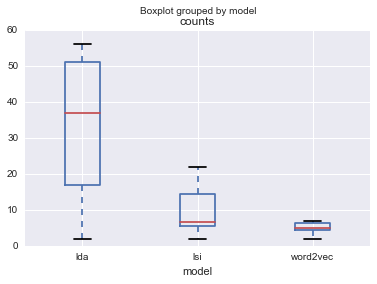

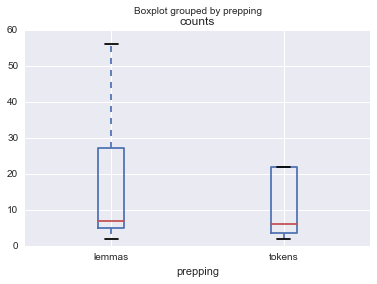

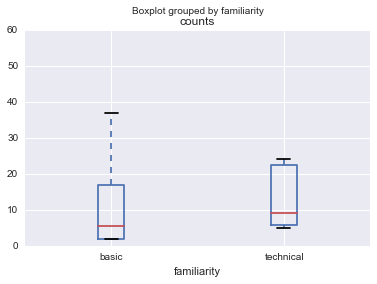

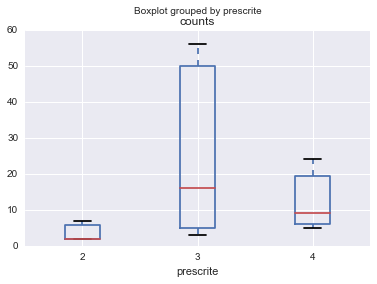

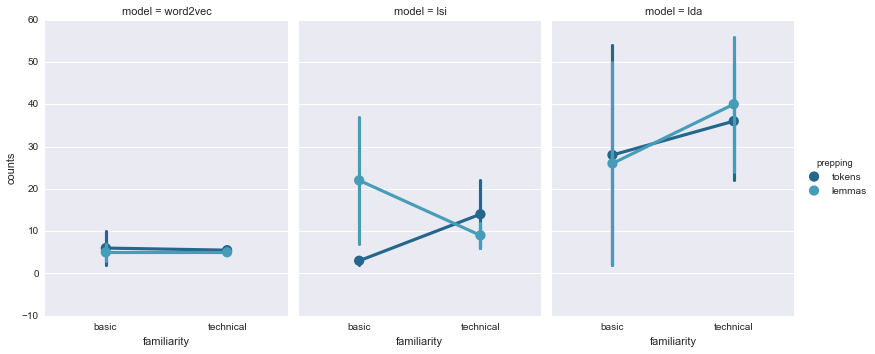

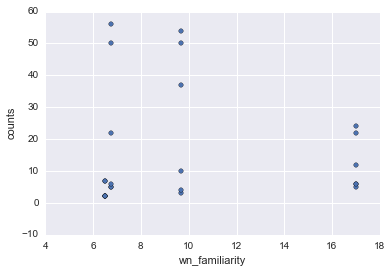

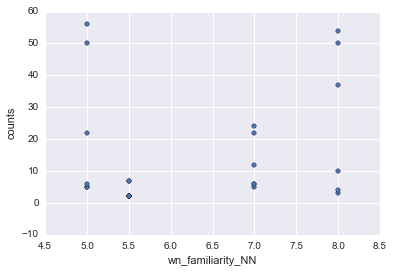

In [30]:
# checking
plots (a)

In [31]:
anovas (a)

                                                         sum_sq  df         F  \
C(model, Sum)                                       3199.750000   2  4.744471   
C(prepping, Sum)                                      35.041667   1  0.103917   
C(familiarity, Sum)                                   63.375000   1  0.187940   
C(model, Sum):C(prepping, Sum)                        66.083333   2  0.097986   
C(model, Sum):C(familiarity, Sum)                    180.750000   2  0.268009   
C(prepping, Sum):C(familiarity, Sum)                  51.041667   1  0.151365   
C(model, Sum):C(prepping, Sum):C(familiarity, Sum)   255.083333   2  0.378228   
Residual                                            4046.500000  12       NaN   

                                                      PR(>F)  
C(model, Sum)                                       0.030325  
C(prepping, Sum)                                    0.752726  
C(familiarity, Sum)                                 0.672327  
C(model, Sum):C(pr

Regression familiarity vs wn_NN


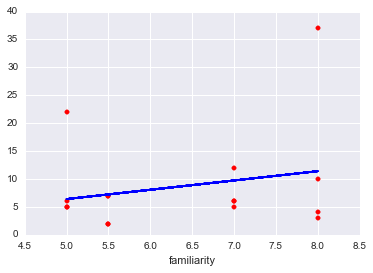

Coefficients: 1.665
Mean residual sum of squares: 71.3
Variance of Y explained by X: 0.052
Regression familiarity vs wn


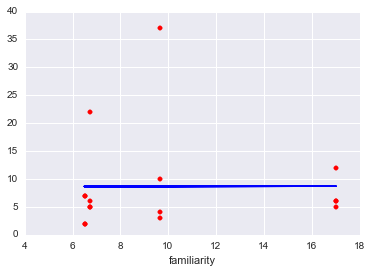

Coefficients: 0.005
Mean residual sum of squares: 75.2
Variance of Y explained by X: 0.000


In [38]:
regressions (a)

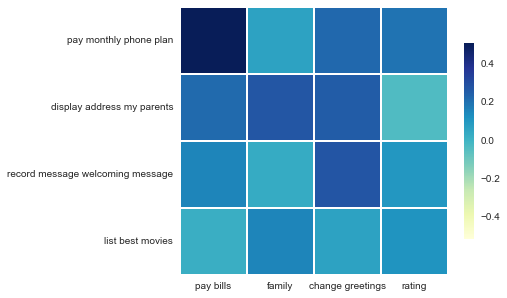

In [40]:
def goal_matrix (test_set):
    goal_index = []
    for goal in test_set:
        goal_index.append(goal[1])

    sim_heatmap = pd.DataFrame(index=goal_index)

    for i, feat in enumerate(test_set):
        sim_features = []
        for j, goal in enumerate(test_set):
            sim_features.append(tok_w2v.n_similarity(feat[0].split(), goal[1].split()) )
        sim_heatmap[feat[0]] = sim_features
    sim_heatmap.head()

    # Plot similarity matrix as heatmap
    f, ax = plt.subplots(figsize=(6, 7))

    # Draw the heatmap 
    sns.heatmap(sim_heatmap,cmap="YlGnBu",
                robust=True,#annot=True,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    
#checking
goal_matrix (test_set_gui)